# Create spot diagram and plot with python

This section exemplarily creates a list of commands that generate a spot diagram, save its contents to a file, and read and plot this file with python. 

## A file with a list of KDP-2 commands:

In [146]:
import numpy as np
def built_spd_mac(file, a, b):
    macroname = 'buildSPD'
    file = open(file, "w")
    def write_line(file, L):
        file.writelines(L)
        file.write("\n")


    #write_line(file, L=['MACRO ' + str(macroname)])
    # FOB ... object point specification, manual p. 159
    # This command defines the object point from which subsequent rays will be traced
    # FOB (qualifier word) , Y, X, Z, n, m

    if isinstance(a, list) and isinstance(b, list):
        #filename = "multi_fob_"+str(a[0])+"_to_"+str(a[-1])+"__"+str(b[0])+"_to_"+str(b[-1])
        for i in range(0, len(a)):
            filename = str(a[i]) + '_' + str(b[i])
            # for one object point specification (field)
            write_line(file, L=['VIG ON'])
            write_line(file, L=['FOB, ' + str(a[i]) + ' ' + str(b[i])])
            write_line(file, L=['SPD'])
            # create an ascii file with the current spd
            write_line(file, L=['AWRTSPOT spd_' + filename])
    else:
        filename = str(a)+'_'+str(b)
        # for one object point specification (field)
        write_line(file, L=['FOB, ' + str(a) + ' '+ str(b)])
        write_line(file, L=['SPD'])
        # create an ascii file with the current spd
        write_line(file, L=['AWRTSPOT spd_'+filename])

    #write_line(file, L=['EOM'])
    file.close()

path_KDP_mac_spd = r'C:\Work\Tools\KDP\create_spd.DAT'
path_KDP_mac_spd_multi = r'C:\Work\Tools\KDP\create_spd_multi.DAT'
built_spd_mac(path_KDP_mac_spd, a = 0.1, b = 0.1)

a = np.linspace(0, 0.1, num = 11)
b = np.linspace(0, 0.1, num = 11)
A,B = np.meshgrid(a,b)
built_spd_mac(path_KDP_mac_spd_multi, a = A.flatten().tolist(), b = B.flatten().tolist())

Now go to KDP-2 and execute the created macro width the command "input file create_spd.DAT" in the command line.

## Open and plot with python
Use the below python function to open and plot the .ASC file created by the KDP-2 "macro", i.e. list of commands:


In [147]:
import os
filename = os.path.join(os.path.dirname(path_KDP_mac_spd_multi), "SPD_0.1_.ASC")
#filename = os.path.join(os.path.dirname(path_KDP_mac_spd_multi), "SPD_0.01.ASC")
def load_spd(filename):
    N_rays = int(np.loadtxt(filename, skiprows=0, max_rows = 1))-1
    spd_L = []
    for n in range(0, N_rays):
        #print("n = ", n)
        spd = np.loadtxt(filename, skiprows=1+n*25, max_rows=25, dtype='str')
        spd = np.char.replace(spd, 'D', 'E').astype(np.float64)
        spd_L.append(spd)
    spd_L = np.array(spd_L)

    # x,y,z, l, m, n and wavelength number of chief ray at object surface
    # see KDP-2 manual, p. 178
    chief_ray_info = np.loadtxt(filename, skiprows = 1+n*25 + 25, max_rows = 6, dtype = 'str')
    chief_ray_info = np.char.replace(chief_ray_info , 'D', 'E').astype(np.float64)
    return chief_ray_info, spd_L

chief_ray_info, spd_L = load_spd(filename)

print(spd_L.shape)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['mathtext.default'] = 'regular'
plt.close("all")
%matplotlib widget



def plot_spot_diag(spd_L, unit = "mum"):
    #unit = "mm"
    if unit == "mum":
        unit = "$\mu$m"
    if unit == "mm":
        fac = 1
    if unit == "$\mu$m":
        fac = 1000
    fig = plt.figure("spd", figsize =(8,8))
    ax = plt.subplot(111)
    ax.title.set_text('spot diagram')
   

    ax.set_xlabel('x-dist. / '+str(unit))
    ax.set_ylabel('y-dist. / '+str(unit))
    plt.minorticks_on()
    plt.grid(which='major', axis='both', color = 'lightgray', linestyle = ':')
    plt.grid(which='minor', axis='both', color = 'lightgray', linestyle = ':')
    plt.subplots_adjust(left=0.25, bottom=0.25, right=None, top=None, wspace=None, hspace=None)

    def centroidnp(arr):
        length = arr.shape[0]
        sum_x = np.nansum(arr[:, 0])
        sum_y = np.nansum(arr[:, 1])
        return sum_x/length, sum_y/length
    
    
    
    ax.tick_params(axis='both', which = 'both', direction = 'in')
    

 
    points_xy = spd_L[:,0,0:2]    # 0 selects x and y, 0:2 keeps both
    points_xy = points_xy[points_xy[:,0] != 0] #= np.nan
    centroid = centroidnp(points_xy)
    
    points_xc = points_xy[:,0]-centroid[0]
    points_yc = points_xy[:,1]-centroid[1]

    
    ax.scatter(points_xc*fac, points_yc*fac, marker = '+', color = 'blue', linewidth = 0.5)
        #print("x = ", points_xc, "y = ", points_yc )
        #points_xc_L.append(points_xc)
        #points_yc_L.append(points_yc)
        

    
    centroidc = (0,0)
    print("centroid: ", centroid)
    
    ax.axhline(y=centroidc[1]*fac, color='green', linestyle='--', linewidth = 0.5)
    ax.axvline(x=centroidc[0]*fac, color='green', linestyle='--', linewidth = 0.5)


    Maxx = np.abs(np.max(points_xc*fac))
    Minx = np.abs(np.min(points_xc*fac))
    Limx = np.max([Maxx,Minx])
    Max = np.abs(np.max(points_yc*fac))
    Min = np.abs(np.min(points_yc*fac))
    Limy = np.max([Max,Min])

    Lim = np.max([Limx,Limy])
    #ax.set_xlim(-Lim,Lim)
    #ax.set_ylim(-Lim,Lim)

    ax.annotate(str(np.round(centroid,decimals = 3))+" mm", (centroidc[0]+Lim/20, centroidc[1]+Lim/20), 
                fontsize = 8, color = 'green')

    start = -np.floor(Lim*10)/10
    end = -start
    stepsize = end/2
    #ax.xaxis.set_ticks(np.arange(start, end+stepsize, stepsize))
    #ax.yaxis.set_ticks(np.arange(start, end+stepsize, stepsize))
    return centroid, points_xc, points_yc

print(chief_ray_info)
print(spd_L.shape)




(165, 25, 2)
[-3.63362810e+18 -3.63362810e+18  0.00000000e+00  3.62884001e-02
  3.62884001e-02  9.98682284e-01]
(165, 25, 2)


Plotting with matplotlib:

centroid:  (3.5854502175502745, 3.5854502175502754)
centroid =  (3.5854502175502745, 3.5854502175502754)


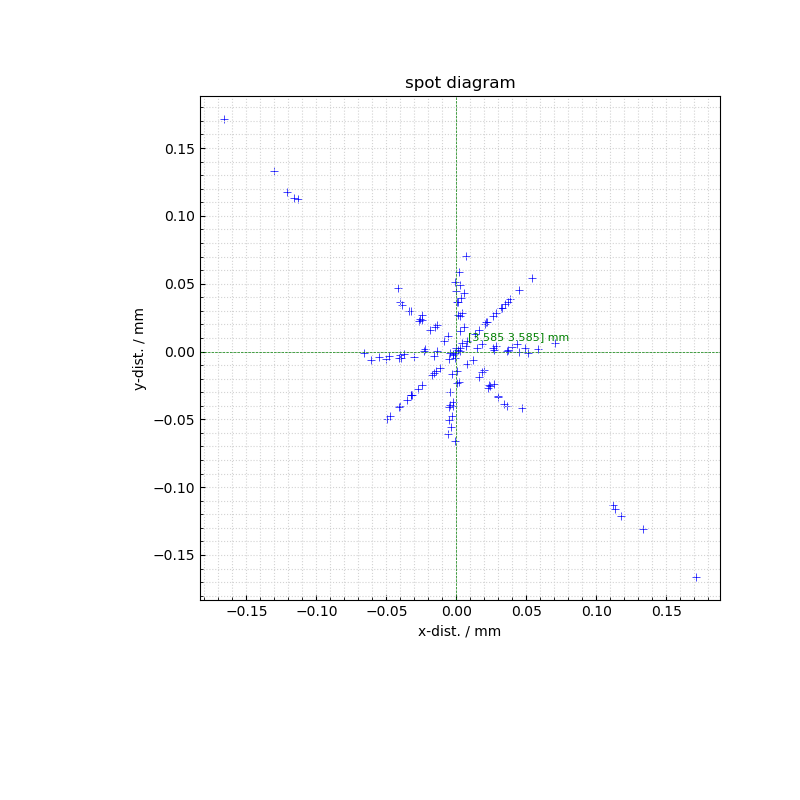

In [148]:
centroid, points_xc, points_yc = plot_spot_diag(spd_L, unit = "mm")
print("centroid = ", centroid)

Using plotly for plotting:

In [149]:
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

In [152]:
df = px.data.iris()
fig = px.scatter(x = points_xc, y = points_yc, labels={"x": "x-dist. / mm","y": "y-dist. / mm"}, template='plotly')
fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
fig
